# Personal Information
Name: **Your Name**

StudentID: **Your Student ID**

Email: [**youremail@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **DD.MM.YYYY**

# Data Context
**In this section you should introduce the datasources and datasets which you will be working with. Explain where they are from as well as their domain. Give an overview of what the context of the data is. You should not spend more than 1 to 2 paragraphs here as the core information will be in the next section.**

# Data Description

**Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**

As you can see, you are in a jupyter notebook environment here. This means that you should focus little on writing text and more on actually exploring your data. If you need to, you can use the amsmath environment in-line: $e=mc^2$ or also in separate equations such as here:

\begin{equation}
    e=mc^2 \mathrm{\space where \space} e,m,c\in \mathbb{R}
\end{equation}

Furthermore, you can insert images such as your data aggregation diagrams like this:

![image](example.png)

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import re
from pydicom import dcmread


### Data Loading
Here the dataset is loaded and state

In [12]:
def load_coordinates(output_file_path, index):
    try:
        output_data = sio.loadmat(output_file_path)
        coordinates_iwp = output_data['output']['Inner_with_Papillary_Muscles'][0, index]
        coordinates_iwop = output_data['output']['Inner_without_Papillary_Muscles'][0, index]
        coordinates_out = output_data['output']['Outer'][0, index]
        return coordinates_iwp, coordinates_iwop, coordinates_out
    except IndexError:
        return None, None, None

In [13]:
def plot_image_with_coordinates(input_image, coordinates_iwp, coordinates_iwop, coordinates_out, image_width,
                                image_height, save_path, filename, index):
    if coordinates_iwp is None or coordinates_iwop is None or coordinates_out is None:
        return  # Skip if coordinates are None
    #Normalizing the coordinates
    for nested_coordinates_iwp, nested_coordinates_iwop, nested_coordinates_out in zip(coordinates_iwp[0],
                                                                                       coordinates_iwop[0],
                                                                                       coordinates_out[0]):
        scaled_coordinates_iwp = nested_coordinates_iwp * np.array([image_width / 255, image_height / 255])
        scaled_coordinates_iwop = nested_coordinates_iwop * np.array([image_width / 255, image_height / 255])
        scaled_coordinates_out = nested_coordinates_out * np.array([image_width / 255, image_height / 255])

        plt.imshow(input_image, cmap='gray')
        plt.plot(scaled_coordinates_iwp[:, 0], scaled_coordinates_iwp[:, 1], c='red', marker='.',
                 label='Inner with Papillary Muscles')
        plt.plot(scaled_coordinates_iwop[:, 0], scaled_coordinates_iwop[:, 1], c='blue', marker='.',
                 label='Inner without Papillary Muscles')
        plt.plot(scaled_coordinates_out[:, 0], scaled_coordinates_out[:, 1], c='green', marker='.',
                 label='Outer contour')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Input Image with Coordinates - ' + filename + '_' + str(index))
        plt.legend()
        plt.savefig(os.path.join(save_path, filename + '_' + str(index) + '.png'))
        plt.close()

In [14]:
# Input paths Cynthia
#input_folder_path = r"/mnt/c/Users/cinth/Documentos/ams/data_science/actual_thesis/codes/UniverSeg-main/UniverSeg-main/example_data/Training/"
#output_folder_path = r"/mnt/c/Users/cinth/Documentos/ams/data_science/actual_thesis/codes/UniverSeg-main/UniverSeg-main/example_data/Training/results"
# Input paths Eveline
input_folder_path = "C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\UniverSeg-eda\\UniverSeg-main\\example_data\\Training\\"
output_folder_path = "C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\UniverSeg-eda\\UniverSeg-main\\example_data\\Training\\results"

In [15]:
# Create the output folder if it doesn't exist and remove existing images
if os.path.exists(output_folder_path):
    for filename in os.listdir(output_folder_path):
        os.remove(os.path.join(output_folder_path, filename))
else:
    os.makedirs(output_folder_path)

KeyboardInterrupt: 

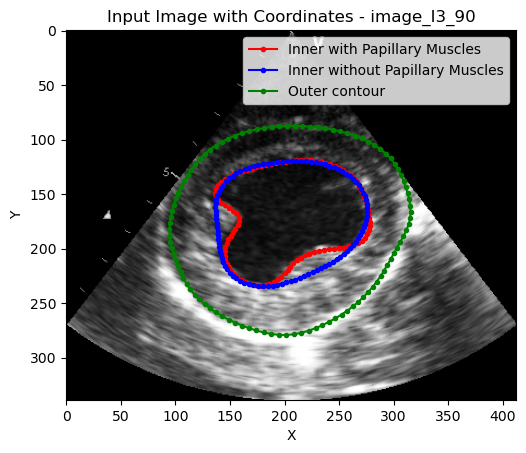

In [19]:
# Loop over all files in the input folder
metadata_list = []
for filename in os.listdir(input_folder_path):
    if re.match(r"I\d+\.mat", filename):
        input_file_path = os.path.join(input_folder_path, filename)

        output_file_path = os.path.join(input_folder_path, "O" + filename[1:])  # Matching output file name
        data = sio.loadmat(input_file_path)
        I_header = data['I']
        tframe_data = I_header['tframe'][0][0]

        # Extract the number of the I file
        file_number = filename[1:-4]

        # Loop over all images in 'dicom' array
        for j, dicom_data in enumerate(tframe_data['dicom'][0], start=0):
            imsave('image.png', dicom_data, cmap='gray')
            # Load the input image
            input_image_path = 'image.png'
            input_image = imread(input_image_path)
            image_height, image_width = input_image.shape[:2]

            # Load the coordinates
            coordinates_iwp, coordinates_iwop, coordinates_out = load_coordinates(output_file_path, j)
            plot_image_with_coordinates(input_image, coordinates_iwp, coordinates_iwop, coordinates_out, image_width,
                                        image_height, output_folder_path, 'image_I' + file_number, j)


### Analysis 1: 
Print different input images to see what the data looks like.

In [3]:
#Print input image

In [ ]:
#Print coordinates over input image

### Analysis 2: 
Data shape

In [4]:
# Print how our data looks like.

### Analysis 3:
Number of images and check for for duplicates

In [ ]:
# number of images -> Run over all I -> print(Nframes)

### Analysis 4: 
Image Id and encoded pixels

### Analysis 5:
Select area of segmentation

### Analysis 6:
Run encoding

In [27]:
def encode_pixels_rle(image_shape, coordinates_iwp, coordinates_iwop, coordinates_out):
    """
    Encode pixel coordinates into a run-length encoded representation.
    
    Parameters:
    - image_shape: Shape of the image (height, width)
    - coordinates_iwp: List of coordinates for the inner wall of the prostate
    - coordinates_iwop: List of coordinates for the inner wall of the prostate outer perimeter
    - coordinates_out: List of coordinates for the outer wall of the prostate
    
    Returns:
    - rle_encoded: Run-length encoded representation of the segmented regions
    """
    # Initialize an empty list to store run-length encoded segments
    rle_encoded = []
    
    # Convert coordinates to binary mask
    binary_mask = np.zeros(image_shape, dtype=np.uint8)
    for coordinates in [coordinates_iwp, coordinates_iwop, coordinates_out]:
        for x, y in coordinates:
            binary_mask[y, x] = 1  # Note the reversal of x and y due to array indexing
    
    # Run-length encoding
    current_pixel_value = binary_mask[0, 0]
    run_length = 0
    for y in range(image_shape[0]):
        for x in range(image_shape[1]):
            pixel_value = binary_mask[y, x]
            if pixel_value == current_pixel_value:
                run_length += 1
            else:
                rle_encoded.append((current_pixel_value, run_length))
                current_pixel_value = pixel_value
                run_length = 1
    rle_encoded.append((current_pixel_value, run_length))  # Append last run-length
    
    return rle_encoded

### Analysis 7:
Check metadata

In [28]:
#input-> header -> Height, Width, Studydate, PatientSex
metadata_list = []
image_shape=(339,413) #NEEDS TO BE CHANGED
for filename in os.listdir(input_folder_path):
    if re.match(r"I\d+\.mat", filename):
        input_file_path = os.path.join(input_folder_path, filename)

        output_file_path = os.path.join(input_folder_path, "O" + filename[1:])  # Matching output file name
        data = sio.loadmat(input_file_path)
        I_header = data['I']
        tframe_data = I_header['tframe'][0][0]

        # Extract the number of the I file
        file_number = filename[1:-4]

        # Loop over all images in 'dicom' array
        for j, dicom_data in enumerate(tframe_data['dicom'][0], start=0):
            coordinates_iwp, coordinates_iwop, coordinates_out = load_coordinates(output_file_path, j)
            encoded_pixels = encode_pixels_rle(image_shape, coordinates_iwp, coordinates_iwop, coordinates_out)
            
            metadata = {
                'FileNumber': file_number,
                'ImageIndex': j,
                'FilePath': os.path.join(output_folder_path, f"{file_number}_{j}.png"),  # Assuming PNG conversion
                'EncodedPixels': encoded_pixels,
               
            }
            metadata_list.append(metadata)

# Convert metadata list to DataFrame
metadata_df = pd.DataFrame(metadata_list)
metadata_df.head(20)


ValueError: not enough values to unpack (expected 2, got 1)

### Analysis 8: